# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import pickle


2022-06-13 17:38:31.369126: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-13 17:38:31.375754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 17:38:31.375773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Data creation 

In [3]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [4]:
boosted_model =  tf.keras.models.load_model('../../pb_file')

boosted_model.summary()


2022-06-13 17:38:38.460070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-13 17:38:38.460104: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-13 17:38:38.460128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-13 17:38:38.460529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [5]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 70 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_rlr = 3
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 4

def units(j): return (j+8)
units_range = 1

In [6]:
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+1)*2

def bit_width(i): return {'bits': (i+1)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

rest_array = [8,10,12]
rest_units_range =  3
bits_range = 7

In [7]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/optimized_model.h5" 
def predicts_path(v) : return f"tests/predicts/optimized_model.npy" 

#path of the qconverted models
def qmodels_path0(i, v, k): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"
def qpredicts_path0(i, v, k): return f"tests/qpredicts/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"


#path of the qtrained models
#path of the qtrained models
def qtrained_models_path(i, v, k): return f"tests/qmodels/qmodels_scatch_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"
def qtrained_predicts_path(i, v, k): return f"tests/qpredicts/qmodels_scatch_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"
def qtrained_predicts_240_path(i, v, k): return f"tests/qpredicts_240/qmodels_scatch_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"

def qtrained_hist_path(i, v, k): return f"tests/qhist/qmodels_scatch_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"
def qrefpredicts_path (i) : return f"qpredicts_epoch={nbr_conv_epoch}/qpredicts<{bit_lenghts(i)},{integer}>.npy"

# 3. Compare the results

In [8]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
     
    else : print(f'{path} already exists')

def exist_std(path,modeltopred):
    cut_indices = np.where(y_test > 0.24/16)[0]
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test[cut_indices]))
     
    else : print(f'{path} already exists')

In [9]:
path = "/atlas/bonnet/Desktop/code/internship_CPPM/presentation test/Qkeras conv/tests/qmodels/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<6,0>_rest=12_v1.h5"
print(qkeras.utils.load_qmodel(path).layers[0].recurrent_quantizer)
print(qkeras.utils.load_qmodel(path).layers[0].kernel_quantizer)
pred =qkeras.utils.load_qmodel(path).predict(x_test)
print(mse(y_test, pred))
""""for i in range(bits_range):
    for v in range (versions_range):
        for k in range (rest_units_range):
            print(qtrained_models_path(i,v,k))
            print(qkeras.utils.load_qmodel(qtrained_models_path(i,v,k)).layers[0].recurrent_quantizer)
            print(qkeras.utils.load_qmodel(qtrained_models_path(i,v,k)).layers[0].kernel_quantizer)"""

{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 6, 'integer': 0, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}
{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 12, 'integer': 0, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}
31250/31250 [==============================] - 40s 1ms/step
9.943244e-06


'"for i in range(bits_range):\n    for v in range (versions_range):\n        for k in range (rest_units_range):\n            print(qtrained_models_path(i,v,k))\n            print(qkeras.utils.load_qmodel(qtrained_models_path(i,v,k)).layers[0].recurrent_quantizer)\n            print(qkeras.utils.load_qmodel(qtrained_models_path(i,v,k)).layers[0].kernel_quantizer)'

## Predictions

In [10]:
model = tf.keras.models.load_model(models_path(0))      
exist(predicts_path(0), model)

ref = "tests/predicts/refpredicts.npy"  
exist(ref, boosted_model)
std_ref = 'tests/std_ref_predicts.npy'
exist_std(std_ref, boosted_model)

for i in range(bits_range):
    for v in range (versions_range):
        for k in range (rest_units_range):

            qmodel0 = qkeras.utils.load_qmodel(qtrained_models_path(i,v,k))        
            exist_std(qtrained_predicts_240_path(i,v,k), qmodel0)

"""
    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        
    exist(qpredicts_path1(i), qmodel1)

    
    qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        
    exist(qpredicts_path2(i), qmodel2)
    qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        
    exist(qpredicts_path3(i), qmodel3)"""
    




tests/predicts/optimized_model.npy already exists
tests/predicts/refpredicts.npy already exists
tests/std_ref_predicts.npy already exists
tests/qpredicts_240/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=8_v0.npy already exists
tests/qpredicts_240/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=10_v0.npy already exists
tests/qpredicts_240/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=12_v0.npy already exists
tests/qpredicts_240/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=8_v1.npy already exists
tests/qpredicts_240/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=10_v1.npy already exists
tests/qpredicts_240/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=12_v1.npy already exists
tests/qpredicts_240/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=8_v2.npy already exists
tests/qpredicts_240/qmodels_scat

'\n    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        \n    exist(qpredicts_path1(i), qmodel1)\n\n    \n    qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        \n    exist(qpredicts_path2(i), qmodel2)\n    qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        \n    exist(qpredicts_path3(i), qmodel3)'

## Plotting

[1.4982201e-05, 1.305117e-05, 1.277519e-05, 1.1361409e-05, 1.2345645e-05, 1.0870437e-05, 1.1848485e-05]
[1.402086e-05, 1.2767987e-05, 1.1572313e-05, 1.19571905e-05, 1.2930333e-05, 1.1913126e-05, 1.1393878e-05]
[1.1295829e-05, 1.4489065e-05, 1.3781536e-05, 1.272502e-05, 1.1878e-05, 1.2569132e-05, 1.2293875e-05]
[1.4064602e-05, 1.5276913e-05, 1.2742744e-05, 1.386295e-05, 1.2462412e-05, 1.3080987e-05, 1.2305384e-05]
[1.4535625e-05, 1.21163075e-05, 1.1161632e-05, 1.2214994e-05, 1.2496313e-05, 1.2222771e-05, 1.3384526e-05]
[1.3558901e-05, 1.3344051e-05, 1.2224576e-05, 1.0566643e-05, 1.15676075e-05, 1.0183494e-05, 1.16603505e-05]
[1.2707918e-05, 1.4050243e-05, 1.1011068e-05, 1.0780037e-05, 1.1490912e-05, 1.1656179e-05, 1.0148152e-05]
[1.3092942e-05, 1.0615802e-05, 1.1178937e-05, 1.2122535e-05, 1.1725918e-05, 1.1048723e-05, 1.2294822e-05]
[1.1736979e-05, 1.2920486e-05, 1.1244647e-05, 1.1714389e-05, 1.1535872e-05, 1.2189897e-05, 1.0759368e-05]
[1.2677918e-05, 1.1708438e-05, 1.0937773e-05, 1.17

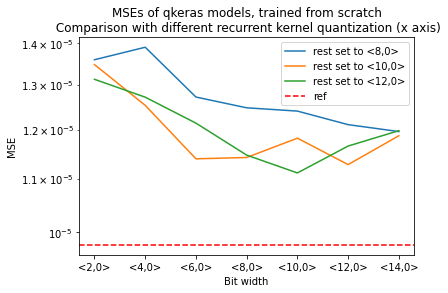

In [11]:
for k in range(rest_units_range):
    loss1 = [] 
    loss2 = [] 
    loss3 = [] 
    yaxis = []
    sum1=0
    sum2=0
    sum3=0
    sum4=0
    sum5=0
    sum6=0
    sum0=0

    yaxis.append('<2,0>')
    yaxis.append('<4,0>')
    yaxis.append('<6,0>')
    yaxis.append('<8,0>')
    yaxis.append('<10,0>')
    yaxis.append('<12,0>')
    yaxis.append('<14,0>')

    for v in range (versions_range):

        loss1 = [] 
        y_kerasref = np.load(ref)
        y_keras0 = np.load(qtrained_predicts_path(0,v,k))
        y_keras1 = np.load(qtrained_predicts_path(1,v,k))
        y_keras2 = np.load(qtrained_predicts_path(2,v,k))
        y_keras3 = np.load(qtrained_predicts_path(3,v,k))
        y_keras4 = np.load(qtrained_predicts_path(4,v,k))
        y_keras5 = np.load(qtrained_predicts_path(5,v,k))
        y_keras6 = np.load(qtrained_predicts_path(6,v,k))

    
        sum0= sum0+mse(y_test,y_keras0)
        sum1= sum1+mse(y_test,y_keras1)
        sum2= sum2+mse(y_test,y_keras2)
        sum3= sum3+mse(y_test,y_keras3)
        sum4= sum4+mse(y_test,y_keras4)
        sum5= sum5+mse(y_test,y_keras5)
        sum6= sum6+mse(y_test,y_keras6)

        
        loss1.append(mse(y_test,y_keras0))  
        
        loss1.append(mse(y_test,y_keras1))
        loss1.append(mse(y_test,y_keras2))        
        loss1.append(mse(y_test,y_keras3))     
        loss1.append(mse(y_test,y_keras4))     
        loss1.append(mse(y_test,y_keras5))  
        loss1.append(mse(y_test,y_keras6)) 
        #plt.plot(loss1,'+')
        print(loss1)
    loss2.append((sum0/versions_range))
    loss2.append((sum1/versions_range))
    loss2.append((sum2/versions_range))
    loss2.append((sum3/versions_range))
    loss2.append((sum4/versions_range))
    loss2.append((sum5/versions_range))
    loss2.append((sum6/versions_range))


    plt.plot(loss2)
    #plt.legend(['bench 1','bench 2','bench 3','mean'])
    plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
    plt.yscale('log')
plt.title(f'MSEs of qkeras models, trained from scratch\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("MSE")
plt.xlabel("Bit width")
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','ref'])



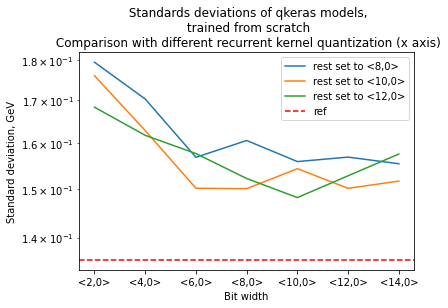

In [15]:
yaxis=[]
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')

cut_indices = np.where(y_test > 0.24/16)[0]
preds = np.load(std_ref)
cut_y = y_test[cut_indices]
reso = preds - cut_y
ref_stdev = np.std(reso*16)
for k in range (rest_units_range):
    std=[]
    for i in range(bits_range):
        stdev_mean=0
        for v in range (versions_range):
            cut_indices = np.where(y_test > 0.24/16)[0]
            preds = np.load(qtrained_predicts_240_path(i,v,k))
            cut_y = y_test[cut_indices]
            reso = preds - cut_y
            stdev = np.std(reso*16)
            stdev_mean=stdev_mean+stdev
        std.append(stdev_mean/versions_range)
    plt.plot(std)
plt.axhline(ref_stdev, linestyle="--", color = 'red')

plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','ref'])
plt.title(f' Standards deviations of qkeras models,\n trained from scratch\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("Standard deviation, GeV")
plt.xlabel("Bit width")
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.yscale('log')
plt.show()

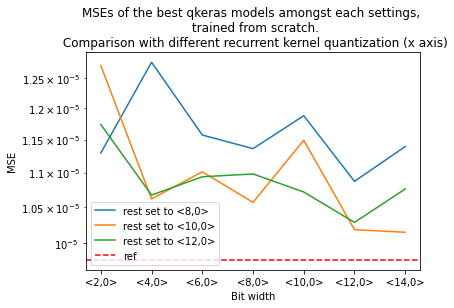

In [14]:
yaxis=[]
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')

for k in range (rest_units_range):
    loss=[]
    for i in range(bits_range):
        best_mse=100
        for v in range (versions_range):
            y_keras0 = np.load(qtrained_predicts_path(i,v,k))
            tmp_mse = mse(y_test,y_keras0)
            if (best_mse>tmp_mse): best_mse=tmp_mse
        loss.append(best_mse)
    plt.plot(loss)
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','ref'])
plt.title(f'MSEs of the best qkeras models amongst each settings, \n trained from scratch.\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("MSE")
plt.xlabel("Bit width")
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.yscale('log')
plt.show()

In [51]:
def loss(i):
    loss=[] 
    return loss

loss0 = []
loss0b = []
loss9 = []
loss9b = []
loss1 = [] 
loss1b = [] 
loss2 = []
loss3 = []

bit_nbr = []


    sum1=0
for v in range (versions_range):
    for i in range(units_range):
        for k in range (rest_units_range):
                y_qkeras0 = np.load(qpredicts_path0(i,v,k))
                sum1= sum1 + mse(y_test,y_qkeras0)
                loss0.append(mse(y_test,y_qkeras0))  
    loss1.append(sum1/versions_range)

plt.figure()
plt.plot(loss0)
plt.plot(loss1,"X")
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>, no weight decay','rest set to <9,0>, no weight decay','rest set to <10,0>, no weight decay', 'ref no decay']) #
plt.xticks(np.arange(len(bit_nbr)), [f"<{Bit},{integer}>" for Bit in bit_nbr])
plt.xlabel('bits settings')
#plt.yscale('log')
plt.ylabel('MSE')
plt.title(f'MSE qkeras, comparison with differente bitwidth for the rkernel, integer={integer}')
plt.show()

IndentationError: unexpected indent (3903258539.py, line 17)

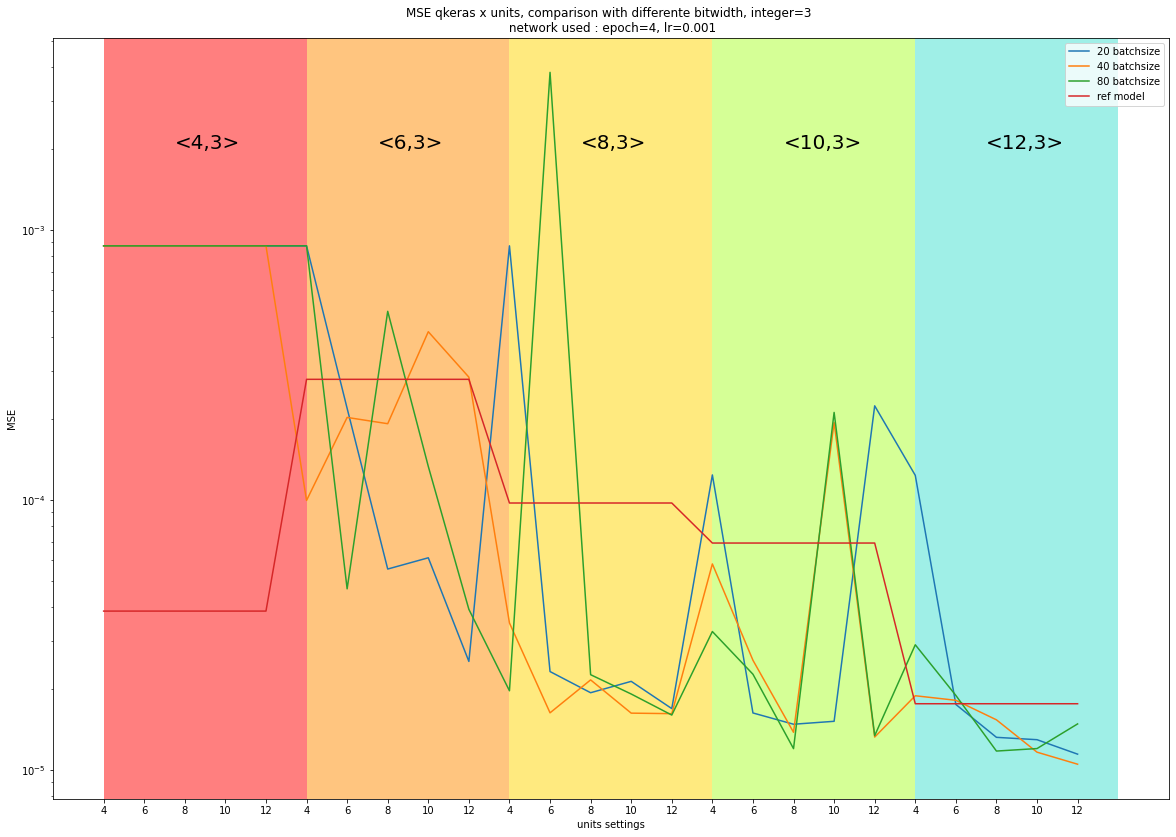

In [ ]:
    plt.figure(figsize=(20,14))
    plt.plot(loss1)
    plt.plot(loss2)
    plt.plot(loss3)
    plt.plot(loss4)
    plt.legend(['20 batchsize','40 batchsize','80 batchsize','ref model'])
    plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
    
    plt.axvspan(0, 5, facecolor='red', alpha=0.5)
    plt.text(1.75, 0.002, "<4,3>", fontsize = 20 )
    plt.text(6.75, 0.002, "<6,3>", fontsize = 20 )
    plt.text(11.75, 0.002, "<8,3>", fontsize = 20 )
    plt.text(16.75, 0.002, "<10,3>", fontsize = 20 )
    plt.text(21.75, 0.002, "<12,3>", fontsize = 20 )
   
    
    plt.axvspan(5, 10, facecolor='darkorange', alpha=0.5)
    plt.axvspan(10, 15, facecolor='gold', alpha=0.5)
    plt.axvspan(15, 20, facecolor='greenyellow', alpha=0.5)    
    plt.axvspan(20, 25, facecolor='turquoise', alpha=0.5)
 
  
    plt.xlabel('units settings')
    plt.yscale('log')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras x units, comparison with differente bitwidth, integer={integer} \n network used : epoch={nbr_conv_epoch}, lr={lr}')
    plt.show()

31250/31250 [==============================] - 43s 1ms/step


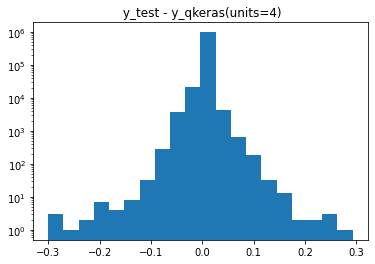

31250/31250 [==============================] - 44s 1ms/step


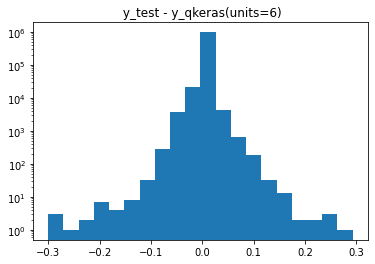

31250/31250 [==============================] - 42s 1ms/step


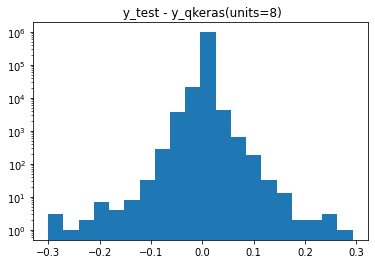

31250/31250 [==============================] - 42s 1ms/step


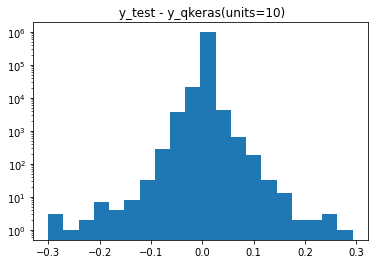

31250/31250 [==============================] - 43s 1ms/step


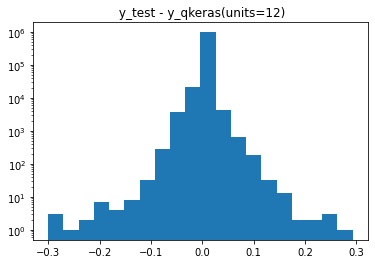

31250/31250 [==============================] - 44s 1ms/step


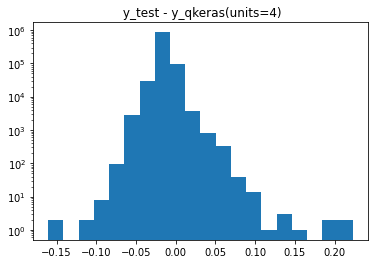

31250/31250 [==============================] - 43s 1ms/step


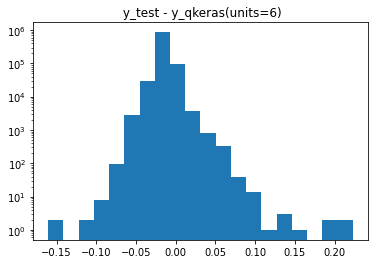

31250/31250 [==============================] - 45s 1ms/step


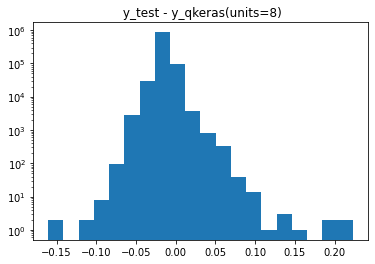

31250/31250 [==============================] - 44s 1ms/step


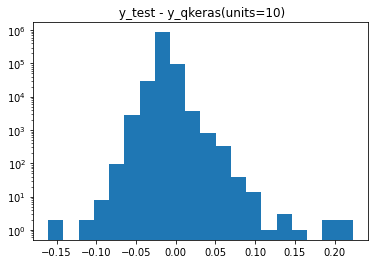

31250/31250 [==============================] - 43s 1ms/step


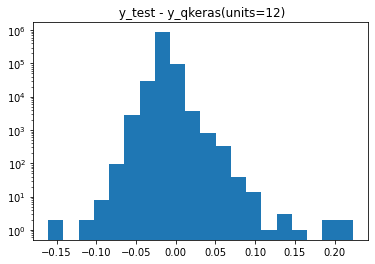

31250/31250 [==============================] - 47s 1ms/step


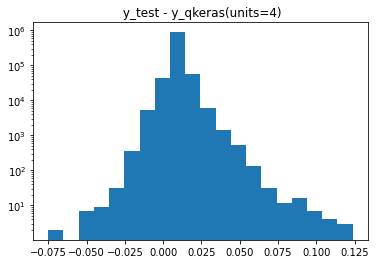

31250/31250 [==============================] - 48s 2ms/step


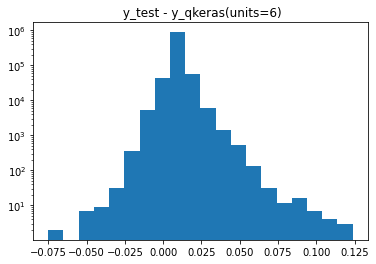

31250/31250 [==============================] - 48s 2ms/step


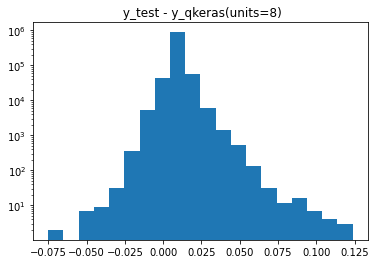

31250/31250 [==============================] - 45s 1ms/step


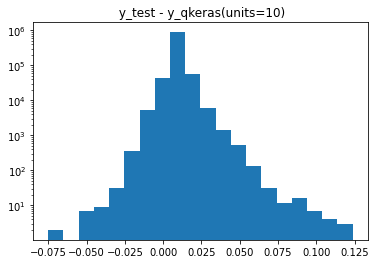

31250/31250 [==============================] - 49s 2ms/step


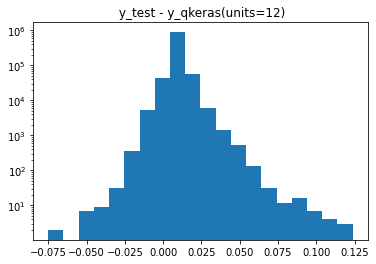

31250/31250 [==============================] - 43s 1ms/step


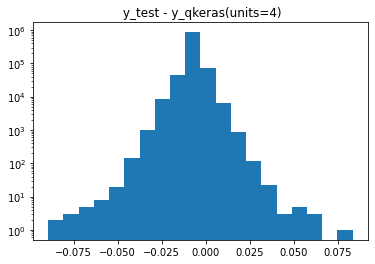

31250/31250 [==============================] - 42s 1ms/step


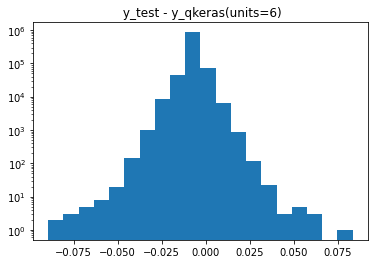

31250/31250 [==============================] - 42s 1ms/step


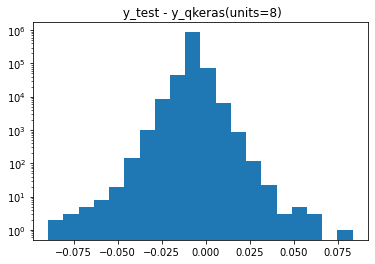

31250/31250 [==============================] - 46s 1ms/step


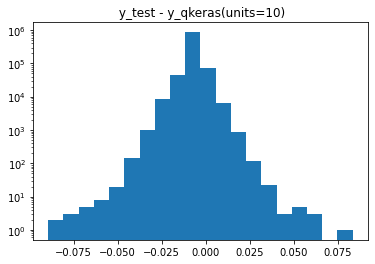

31250/31250 [==============================] - 44s 1ms/step


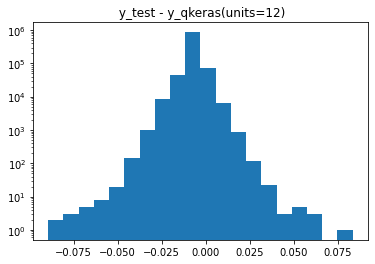

31250/31250 [==============================] - 44s 1ms/step


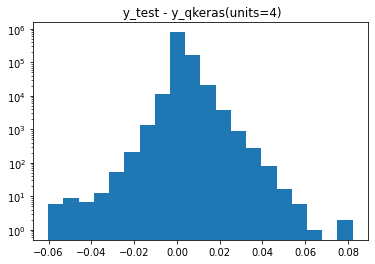

31250/31250 [==============================] - 45s 1ms/step


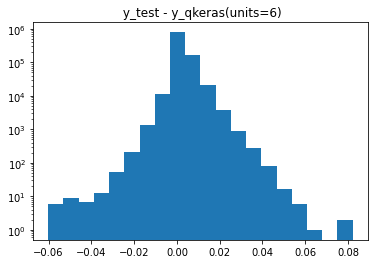

31250/31250 [==============================] - 46s 1ms/step


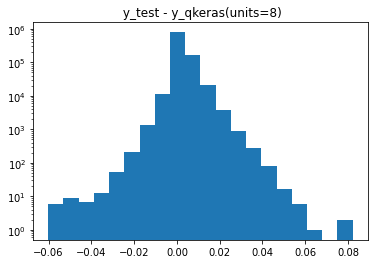

31250/31250 [==============================] - 49s 2ms/step


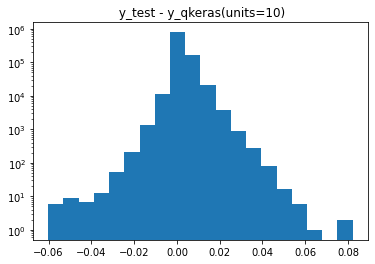

31250/31250 [==============================] - 48s 2ms/step


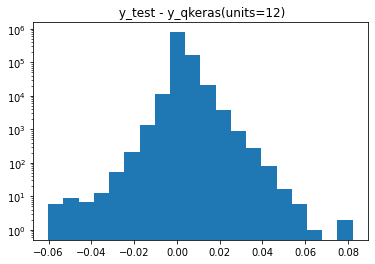

In [ ]:
bit_nbr = []
loss3 = []
loss4 = []
unit_nbr = []

for i in range(bits_range):
        qmodel4 = qkeras.utils.load_qmodel(f'qmodels_epoch=4/qmodels_units,<{bit_lenghts(i)},3>.h5')        
        y_qkeras4 = qmodel4.predict(x_test)
        for j in range(units_range):
                qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(j,i))        
                y_qkeras3 = qmodel3.predict(x_test)                        

                loss3.append(mse(y_test,y_qkeras3))
                loss4.append(mse(y_test,y_qkeras4))

                plt.figure()
                plt.hist(y_test-y_qkeras4, bins=20)
                plt.yscale('log')
                plt.title(f' y_test - y_qkeras(units={units(j)})')
                plt.show()